In [49]:
# import sys
# sys.path.insert(1, 'my_utils')

In [50]:
import warnings
import librosa
import os
import pdb
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import get_window
from pathlib import Path
from tqdm import tqdm


In [100]:
# FROM PERSONAL UTILITY REPO

def audio_io(file_path, trg_sr):
    with warnings.catch_warnings(): # warning 
        warnings.simplefilter("ignore", category=UserWarning)
    file_path = str(file_path)
    if file_path.endswith('.m4a'):
        y, _ = librosa.load(file_path, sr=trg_sr)
    else:
        y, samplerate = sf.read(file_path)
        if samplerate != trg_sr:
            if not y.flags['F_CONTIGUOUS']:
                y = librosa.resample(np.asfortranarray(y), orig_sr=samplerate, target_sr=trg_sr)
            else:
                y = librosa.resample(y, orig_sr=samplerate, target_sr=trg_sr)
    return y

""" Filter out unwanted frequencies by determining nyquist freq and defining a floor frequency (cutoff)"""
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


""" stft transform """
def pySTFT(x, fft_length=1024, hop_length=256):
    x = np.pad(x, int(fft_length//2), mode='reflect')
    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T
    return np.abs(result)


"""applies stft transform to audio, then mel filter banks"""
def audio_to_mel_autovc(audio, fft_size, hop_length: int, mel_filter):
    D = pySTFT(audio, fft_size, hop_length).T
    db_unnormed_melspec = np.dot(D, mel_filter)
    return db_unnormed_melspec


""" qian way"""
def raw_audio_to_mel_autovc(y, mel_filter, min_level, hop_length, sr, fft_size):   
    y = add_butter_noise(y, sr)
    db_unnormed_melspec = audio_to_mel_autovc(y, fft_size, hop_length, mel_filter)
    autovc_mel = db_normalize(db_unnormed_melspec, min_level)
    return autovc_mel


"""adds a highpass filter to audio, then injects small amount of noise"""
def add_butter_noise(audio, sr):
    prng = np.random.RandomState(1)
    b, a = butter_highpass(30, sr, order=5)
    y = signal.filtfilt(b, a, audio)
    wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
    return wav


# returns a list of filepaths collected from a parent directory and all subdirectories
def recursive_file_retrieval(parent_path, ignore_hidden_dirs=False, return_parent=True):
    
    file_path_list = []
    dir_list = []
    parent_paths = [parent_path]

    more_subdirs = True
    while more_subdirs == True:
        subdir_paths = []
        for i, parent_path in enumerate(parent_paths):
            # print(parent_path)
            if ignore_hidden_dirs:
                if os.path.basename(parent_path).startswith('.'):
                    continue

            dir_list.append(parent_path)
            r,dirs,files = next(os.walk(parent_path, topdown=True, onerror=None, followlinks=False)) 
            for f in files:
                file_path_list.append(os.path.join(r,f))

            # if there are more subdirectories
            if len(dirs) != 0:
                for d in dirs:
                    subdir_paths.append(os.path.join(r,d))

            # if we've finished going through subdirectories (each parent_path), stop that loop
            if i == len(parent_paths)-1:
                # if loop about to finish, change parent_paths content and restart loop
                if len(subdir_paths) != 0:
                    parent_paths = subdir_paths
                else:
                    more_subdirs = False
    
    if not return_parent: dir_list = dir_list[1:]

    return dir_list, file_path_list


"""Converts amplitude to decibels and optionally normalises"""
def db_normalize(melspec, min_level, normalise=True):
    floored_mel = np.maximum(min_level, melspec) # creates a new array, clipping at the minimum_level
    db_melspec = 20 * np.log10(floored_mel) - 16 # converts to decibels (20*log10) and removes 16db for headroom
    if normalise:
        db_clipped_melspec = np.clip((db_melspec + 100) / 100, 0, 1) # Add 100 to ensure the minimal value is at least 0 before. Clip from 0 to 1 anyway
        return db_clipped_melspec
    else:
        return db_melspec


# normalise
def unit_var(arr):
    return (arr - np.mean(arr)) / np.std(arr)


# save transforms to disk as dataset without any predefined splits
def get_dst_fp(fp, dst_dir):
    # if type(feat) == np.ndarray:
    fp_ob = Path(fp)
    fp_dir_name = fp_ob.parent.name
    dst_dir_genre = os.path.join(dst_dir, fp_dir_name)
    if not os.path.exists(dst_dir_genre):
        os.mkdir(dst_dir_genre)
    dst_fp = os.path.join(dst_dir_genre, fp_ob.name)
    dst_fp = dst_fp[:-4] +'.npy'
    # np.save(dst_fp, feat)
    return dst_fp


def plot_im(im):

    # Plot the time series
    plt.imshow(np.rot90(im[:200]))
    plt.xlabel('timesteps')
    plt.ylabel('mel bins')
    plt.colorbar()
    plt.show()
    plt.close()

In [68]:
# get fps
source_dir = '/Users/brendanoconnor/Downloads/MLExcerciseBrendan/data/GTZAN/genres_original'
test_dir = '/Users/brendanoconnor/Downloads/MLExcerciseBrendan/data/GTZAN/data_small'
trg_sr = 16000
hop = 256
n_fft = 1024
dim_size = 80
fmin = 90
fmax = 7600

min_level = np.exp(-100 / 20 * np.log(10))
mel_filter = librosa.filters.mel(sr=16000, n_fft=1024, fmin=90, fmax=7600, n_mels=80).T
dst_dir = '/Users/brendanoconnor/Desktop/career/tempoEstimationTask/stored_feats'

feat_params = {'num_mels': dim_size,
                'sr':trg_sr,
                'fft_size':n_fft,
                'hop_size': hop,
                "fmin": fmin,
                "fmax":fmax
                }

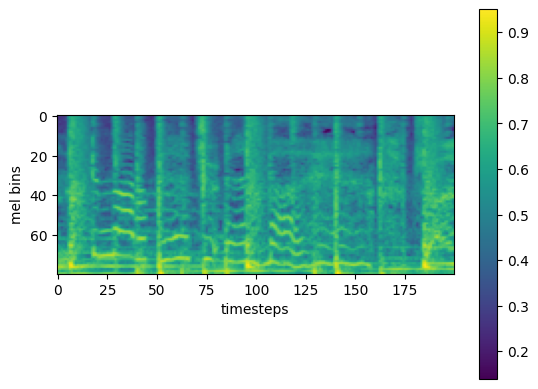

In [95]:

_, test_fps = recursive_file_retrieval(test_dir, ignore_hidden_dirs=True)
test_fps = [i for i in test_fps if not os.path.basename(i).startswith('.')]
fp = test_fps[0]
w = audio_io(fp, trg_sr=trg_sr)
m = raw_audio_to_mel_autovc(w, mel_filter, min_level, hop, trg_sr, n_fft)
plot_im(m)

In [88]:
import yaml
yaml_file_path = os.path.join(dst_dir, 'feat_params.yaml')

with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(feat_params, yaml_file, default_flow_style=False)

In [107]:
_, fps = recursive_file_retrieval(source_dir, ignore_hidden_dirs=True)
fps = [i for i in fps if not os.path.basename(i).startswith('.')]

for fp in tqdm(fps):
    dst_fp = get_dst_fp(fp, dst_dir)
    if os.path.exists(dst_fp):
        continue
    try:
        w = audio_io(fp, trg_sr=trg_sr)
        m = raw_audio_to_mel_autovc(w, mel_filter, min_level, hop, trg_sr, n_fft)
        np.save(dst_fp, m)
    except Exception as e:
        print(f'Issue with fp {fp}. Skipping for now.')

100%|██████████| 1000/1000 [00:00<00:00, 4033.78it/s]

Issue with fp /Users/brendanoconnor/Downloads/MLExcerciseBrendan/data/GTZAN/genres_original/jazz/jazz.00054.wav. Skipping for now.


In [105]:
qwe = dst_fp[:-5] +'1.npy'
os.path.exists(qwe)

True

In [ ]:
# get melspecs
wavs = []
for i, fp in tqdm(enumerate(fps)):
    try:
        wav = audio_io(fp, trg_sr=trg_sr)
    except Exception as e:
        print(f'Error with file {fp} at index {i}. Skipping for now.')
    wavs.append((wav, fp))